In [85]:
import time
import torch

from torch import nn, Tensor

# flow_matching
from flow_matching.path.scheduler import CondOTScheduler
from flow_matching.path import AffineProbPath
from flow_matching.solver import Solver, ODESolver
from flow_matching.utils import ModelWrapper

# visualization
import matplotlib.pyplot as plt

from matplotlib import cm


# To avoide meshgrid warning
import warnings

warnings.filterwarnings("ignore", category=UserWarning, module='torch')

In [86]:
# Activation class
class Swish(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, x: Tensor) -> Tensor: 
        return torch.sigmoid(x) * x

# Model class
class MLP(nn.Module):
    def __init__(self, input_dim: int = 2, time_dim: int = 1, hidden_dim: int = 128):
        super().__init__()
        
        self.input_dim = input_dim
        self.time_dim = time_dim
        self.hidden_dim = hidden_dim

        self.main = nn.Sequential(
            nn.Linear(input_dim+time_dim, hidden_dim),
            Swish(),
            nn.Linear(hidden_dim, hidden_dim),
            Swish(),
            nn.Linear(hidden_dim, hidden_dim),
            Swish(),
            nn.Linear(hidden_dim, hidden_dim),
            Swish(),
            nn.Linear(hidden_dim, input_dim),
            )
    

    def forward(self, x: Tensor, t: Tensor) -> Tensor:
        sz = x.size()
        x = x.reshape(-1, self.input_dim)
        t = t.reshape(-1, self.time_dim).float()

        t = t.reshape(-1, 1).expand(x.shape[0], 1)
        h = torch.cat([x, t], dim=1)
        output = self.main(h)
        
        return output.reshape(*sz)

In [87]:
def inf_train_gen(batch_size: int = 200, device: str = "cpu"):
    x1 = torch.rand(batch_size, device=device) * 4 - 2
    x2_ = torch.rand(batch_size, device=device) - torch.randint(high=2, size=(batch_size, ), device=device) * 2
    x2 = x2_ + (torch.floor(x1) % 2)

    data = 1.0 * torch.cat([x1[:, None], x2[:, None]], dim=1) / 0.45
    
    return data.float()

In [88]:
#x_s = inf_train_gen(batch_size=3, device='cpu') # sample data

In [89]:
#x_s

In [90]:
x_s.shape[0]

3

In [92]:
# training arguments
lr = 0.001
batch_size = 4096
iterations = 2000
print_every = 200 
hidden_dim = 512

# velocity field model init
vf = MLP(input_dim=2, time_dim=1, hidden_dim=hidden_dim) 

# instantiate an affine path object
path = AffineProbPath(scheduler=CondOTScheduler())

# init optimizer
optim = torch.optim.Adam(vf.parameters(), lr=lr) 

# train
start_time = time.time()
for i in range(iterations):
    optim.zero_grad() 

    # sample data (user's responsibility): in this case, (X_0,X_1) ~ pi(X_0,X_1) = N(X_0|0,I)q(X_1)
    x_1 =  inf_train_gen(batch_size=batch_size)
    x_0 = torch.randn_like(x_1)

    # sample time (user's responsibility)
    t = torch.rand(x_1.shape[0]) 

    # sample probability path
    path_sample = path.sample(t=t, x_0=x_0, x_1=x_1)

    # flow matching l2 loss
    loss = torch.pow( vf(path_sample.x_t,path_sample.t) - path_sample.dx_t, 2).mean() 

    # optimizer step
    loss.backward() # backward
    optim.step() # update
    
    # log loss
    if (i+1) % print_every == 0:
        elapsed = time.time() - start_time
        print('| iter {:6d} | {:5.2f} ms/step | loss {:8.3f} ' 
              .format(i+1, elapsed*1000/print_every, loss.item())) 
        start_time = time.time()

| iter    200 | 266.64 ms/step | loss    3.915 
| iter    400 | 256.13 ms/step | loss    3.818 
| iter    600 | 293.10 ms/step | loss    3.850 
| iter    800 | 257.42 ms/step | loss    3.829 
| iter   1000 | 254.22 ms/step | loss    3.817 
| iter   1200 | 285.87 ms/step | loss    3.673 
| iter   1400 | 299.92 ms/step | loss    3.765 
| iter   1600 | 307.71 ms/step | loss    3.791 
| iter   1800 | 307.70 ms/step | loss    3.736 
| iter   2000 | 307.85 ms/step | loss    3.808 


In [93]:
x_0

tensor([[-1.8367, -0.9196],
        [ 0.3790, -0.6559],
        [ 1.1187,  0.8357],
        ...,
        [-0.1781,  0.0711],
        [-0.0743, -0.5434],
        [ 0.8896, -0.8158]])

In [94]:
#t

In [95]:
#path_sample

In [96]:
#vf(path_sample.x_t,path_sample.t)

In [97]:
class WrappedModel(ModelWrapper):
    def forward(self, x: torch.Tensor, t: torch.Tensor, **extras):
        return self.model(x, t)

wrapped_vf = WrappedModel(vf)

In [98]:
# step size for ode solver
step_size = 0.05

norm = cm.colors.Normalize(vmax=50, vmin=0)

batch_size = 100000  # batch size
eps_time = 1e-2
T = torch.linspace(0,1,10)  # sample times


x_init = torch.randn((batch_size, 2), dtype=torch.float32)
solver = ODESolver(velocity_model=wrapped_vf)  # create an ODESolver class
sol = solver.sample(time_grid=T, x_init=x_init, method='midpoint', step_size=step_size, return_intermediates=True)  # sample from the model


In [99]:
#sol

In [100]:
sol.shape

torch.Size([10, 100000, 2])

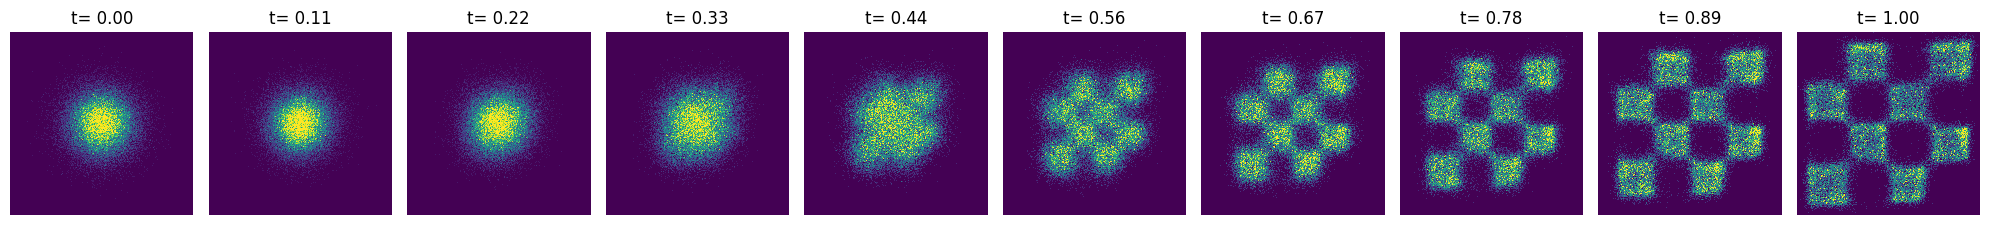

In [101]:
sol = sol.cpu().numpy()
T = T.cpu()

fig, axs = plt.subplots(1, 10,figsize=(20,20))

for i in range(10):
    H= axs[i].hist2d(sol[i,:,0], sol[i,:,1], 300, range=((-5,5), (-5,5)))
    
    cmin = 0.0
    cmax = torch.quantile(torch.from_numpy(H[0]), 0.99).item()
    
    norm = cm.colors.Normalize(vmax=cmax, vmin=cmin)
    
    _ = axs[i].hist2d(sol[i,:,0], sol[i,:,1], 300, range=((-5,5), (-5,5)), norm=norm)
    
    axs[i].set_aspect('equal')
    axs[i].axis('off')
    axs[i].set_title('t= %.2f' % (T[i]))
    
plt.tight_layout()
plt.show()